In [2]:
import cv2
import numpy as  np
import matplotlib.pyplot as  plt
import random
from  glob import  glob
import os
import cv2
import random
from torch import optim
from tqdm import tqdm
from torch.utils.data import Dataset
import torch
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [124]:
class Generate_Img():
    def __init__(self,obj_n=1,img_s=640,angle_rota=(-45,45)):
        self.obj_n = obj_n
        self.img_s = img_s
        self.angle_rota = angle_rota
    
    
    def draw_rota_img(self):
        obj_n=self.obj_n 
        img_s=self.img_s
        angle_rota=(-45,45)
    
        img = np.full((img_s,img_s,3), 255)

        rcc = random_class_color(nc=obj_n)
        
        
        i,color = rcc.rand_c_c()
        img,x,y,w,h = draw_box(img,color)

        img_rota,angle_r = ImageRotate(img,center = (x+w/2,y+h/2),angle = angle_rota, scale = 1)
        labels = [x/img_s,y/img_s,w/img_s,h/img_s]#,i,angle_rota/180])
        ni=np.zeros(10)
        ni[i]=1.0
        labels.extend(ni)
        nr=np.zeros(10)
        nr[int((angle_rota[1]+angle_r)/10)]=1.0
        labels.extend(nr)
        labels.append(((angle_rota[1]+angle_r)%10)*0.1)

        return img,img_rota,np.array([labels])
    
    def draw_img(self,num=5,img_s=1000,n=5):
        obj_n=self.obj_n 
        
        img = np.full((img_s,img_s,3), 255)
        img = np.asarray(img,dtype=np.uint8)
        img_mask = img.copy()
        
        rcc = random_class_color(nc=obj_n)
        
        for _ in range(n):
            i,color = rcc.rand_c_c()
            
            for _ in range(num):
                img_w,img_h = img.shape[:2]
                x0,x1,y0,y1 = get_box(img_h,img_w)

                points = get_polygon(x0,x1,y0,y1,n=20)
                img,points = draw_ploygon(img,points,scale=0.2,color=color,s=3)
                img_mask = cv2.fillPoly(img_mask, [points], color)

        return img,img_mask
    
    def draw_box_img(self,nc=1,n=5):
        rcc=random_class_color(nc)

        r_img,f_img,o_r_img,o_f_img,boxs_xywh,boxs_xy4,boxs_rota=draw_angl_box(n=n,img_h=2000,img_w=2000,ponits=4,xywh=False,xy4=False,scale=0.4,rota=False,rcc=rcc)
        return r_img,f_img

In [127]:
gi = Generate_Img()
img,mask = gi.draw_box_img()

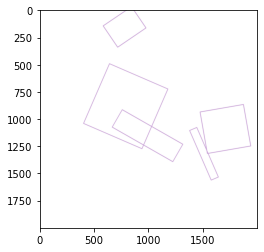

In [128]:
plt.imshow(img)

In [88]:
def draw_box(img,color):
    img_w,img_h = img.shape[:2]
    
    img = np.asarray(img,dtype=np.uint8)

    x,y=np.random.randint(img_w/20,img_w/2,2)
    w,h=np.random.randint(img_h/20,img_h/2,2)
    img = cv2.rectangle(img, (x,y), (x+w,y+h),color, -1)
    
    return img,x,y,w,h

class random_class_color():
    def __init__(self,nc=10,prob_index=[0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1]):
        self.nc=nc
        self.prob_index=prob_index
        self.colors=[[random.randint(0, 255) for _ in range(3)] for __ in range(0,nc)]
    def rand_c_c(self):
        c = np.random.random(1)
        for i, pi in enumerate(self.prob_index):
            if pi > c:
                return i,self.colors[i%self.nc]
        i=random.randint(0,self.nc)
        return i,self.colors[i]
    
# 定义旋转函数
def ImageRotate(image,center = (150,150),angle =(-180, 180), scale = 1):
    height, width = image.shape[:2]    # 输入(H,W,C)，取 H，W 的值
    # center = (width / 2, height / 2)   # 绕图片中心进行旋转
    # # 绕图片中心进行旋转
    angle = random.randint(angle[0],angle[1])  # 旋转方向取（-180，180）中的随机整数值，负为逆时针，正为顺势针
    # scale = 0.8                        # 将图像缩放为80%
#     if angle==0:
#         angle = random.randint(angle[1]/2,angle[1])
    # 获得旋转矩阵
    M = cv2.getRotationMatrix2D(center, angle, scale)
    # 进行仿射变换，边界填充为255，即白色，默认为0，即黑色
    image_rotation = cv2.warpAffine(src=image, M=M, dsize=(height, width), borderValue=(255, 255, 255))
 
    return image_rotation,angle

def generate_mask_boundary(img,color):    
    
    img_mask = img.copy()

    img_w,img_h = img.shape[:2]
    img = np.asarray(img,dtype=np.uint8)
    img_mask = np.asarray(img_mask,dtype=np.uint8)

    x,y=np.random.randint(img_w/20,img_w/2,2)
    w,h=np.random.randint(img_h/20,img_h/2,2)

    img = cv2.rectangle(img, (x,y), (x+w,y+h),color, 2)

    img_mask = cv2.rectangle(img_mask, (x,y), (x+w,y+h),color, -1)
    
    return img,img_mask

In [42]:
def get_box(img_h,img_w,scale=0.2):      
    
    a = []
    for i in range(4):
        if i == 0:
            h = img_h
            w = img_w
            y0, x0 = int(np.random.random(1) * h), int(np.random.random(1) * w)
            a.append([y0, x0])
        else:
            h = img_h *scale
            w = img_w *scale
            a.append([y0 + int((np.random.random(1) - 0.5) * h), x0 + int((np.random.random(1) - 0.5) * w)])

    cnt = np.array(a)
    # rect = cv2.minAreaRect(cnt)  # 得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
    # box = np.int0(cv2.boxPoints(rect))  # 通过box会出矩形框
            
    x0,x1 = cnt[:,0].min(),cnt[:,0].max()
    y0,y1 = cnt[:,1].min(),cnt[:,1].max()
    return x0,x1,y0,y1

def get_polygon(x0,x1,y0,y1,n=20):
    a=[]
    h = y1-y0
    w = x1-x0
    for _  in range(n):
        y_, x_ = int(np.random.random(1) * h+y0), int(np.random.random(1) * w+x0)
        a.append([y_, x_])

    points = np.array(a)
    
    return points

def draw_ploygon(img,points,scale=0.2,color=None,s=2):
    # from scipy.spatial import ConvexHull, convex_hull_plot_2d
    # # points = np.random.rand(30, 2)   # 30 random points in 2-D
    # hull = ConvexHull(points)

    hull = cv2.convexHull(points)

    length = len(hull)
    points = []
    for i in range(len(hull)):
        cv2.line(img, tuple(hull[i][0]), tuple(hull[(i+1)%length][0]),color, s)
        points.append(hull[i][0])
    points =  np.array(points)
    return img, points

In [61]:
img = np.zeros((640,640,3))
color = (255,255,255)

img = np.asarray(img,dtype=np.uint8)

for _ in range(5):
    img_w,img_h = img.shape[:2]
    x0,x1,y0,y1 = get_box(img_h,img_w)

    points = get_polygon(x0,x1,y0,y1,n=20)

    img, points = draw_ploygon(img,points,color=color,scale=0.2)


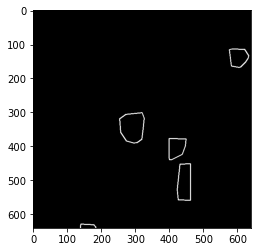

In [62]:
plt.imshow(img)

In [2]:
from generate_img import GenerateDataset

In [3]:
generatedataset = GenerateDataset(obj_n=5, img_s=640, cn=5, n=5)

In [6]:
img,img_mask,points = generatedataset.__getitem__(0)

In [89]:
def draw_angl_box(n=5,ponits=4,img_h=1000,img_w=1000,xywh=True,xy4=False,rota=False,scale=0.2,rcc=None):
    img=np.full((img_h,img_w,3),255,dtype=np.uint8)
    result2=img.copy()
    result3=img.copy()
    result4=img.copy()
    
    boxs_xywh=[]
    boxs_xy4=[]
    boxs_rota=[]
    for _ in range(n):
        a=[]
        for i in  range(ponits):
            if i==0: 
                h=img_h
                w=img_w
                y0,x0=int(np.random.random(1)*h),int(np.random.random(1)*w)
                a.append([y0,x0])
            else:
                h=img_h*scale
                w=img_w*scale
                a.append([y0+int((np.random.random(1)-0.5)*h),x0+int((np.random.random(1)-0.5)*w)])
        
        cnt = np.array(a)

        rect = cv2.minAreaRect(cnt) # 得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
        box = np.int0(cv2.boxPoints(rect)) #通过box会出矩形框

        cindex,color=rcc.rand_c_c()

        result3=cv2.polylines(result3, [cnt],isClosed=True,color=color,thickness=5)
        result4=cv2.fillPoly(result4,[cnt],color)
        
        result1=cv2.polylines(img, [box],isClosed=True,color=color,thickness=5)
        result2=cv2.fillPoly(result2,[box],color)

        box=np.array(box)
        box[box<0]=0
        if img_w==img_h:box[box>img_h]=img_h
        else:
            print("w!=h")
            
        if xy4:
            box_xy=[cindex]
            for x,y in box:box_xy.extend([x,y])
            
            boxs_xy4.append(box_xy)
            
        if xywh:
            x=box[:,1]
            y=box[:,0]
            x0=x.min()
            y0=y.min()
            x1=x.max()
            y1=y.max()
            
            box_xywh=[cindex,(y0+y1)/2.0,(x0+x1)/2.0,y1-y0,x1-x0]
            boxs_xywh.append(box_xywh)
        if rota:
            x0,y0,w,h,rotaing=rect[0][0],rect[0][1],rect[1][0],rect[1][1],rect[2]
            x0-=w/2
            y0-=h/2
            x1=x0+w
            y1=y0+h
            if x0<0:x0=0
            if y0<0:y0=0
            if x1>img_w:x1=img_w
            if y1>img_h:y1=img_h
            boxs_rota.append([cindex,(x0+x1)/2,(y0+y1)/2,x1-x0,y1-y0,rotaing])
            
    return result1,result2,result3,result4,np.array(boxs_xywh),np.array(boxs_xy4),np.array(boxs_rota)


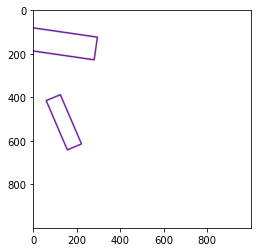

In [100]:
plt.imshow(r_img)